## Прогнозирование Лояльности: Анализ Оттока Клиентов Банка

**Аналитическая задача** — Сравнение клиентов банка

### Задачи проекта:

- Глубокий анализ клиентской базы для выявления факторов, влияющих на отток.
- Создание моделей для прогнозирования оттока и разработки стратегий удержания. 

### Описание данных:

|Признак|Описание признака|
|---:|:---|
|`userid`|идентификатор пользователя|
|`score`|баллы кредитного скоринга|
|`City`|город|
|`Gender`|пол|
|`Age`|возраст|
|`Objects`|количество объектов в собственности|
|`Balance`|баланс на счете|
|`Products`|количество продуктов, которыми пользуется клиент|
|`CreditCard`|есть ли кредитная карта|
|`Loyalty`|активный клиент|
|`estimated_salary`|заработная плата клиента|
|`Churn`|ушел или нет|

### План по выполнению проекта:

- проверяем гипотезы о наличие различий в значениях этих признаков в разрезе целевого признака для количественных признаков `score`, `Balance` и `estimated_salary`.

- рассчитаем оценки выборочных средних и медиан, построим гистограммы и функции плотности.

!!! Предварительную подготовку опустим, будем строить гипотезы на неподготовленных данных.  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import (shapiro, kstest,
                         ks_2samp, anderson,
                         jarque_bera,
                         ttest_ind,
                         mannwhitneyu,
                         kruskal)
from scipy.stats import (pearsonr,
                         spearmanr,
                         pointbiserialr,
                         kendalltau)

In [2]:
df = pd.read_csv('bank_dataset (1).csv')
df.head(2)

,userid,score,City,Gender,Age,Objects,Balance,Products,CreditCard,Loyalty,estimated_salary,Churn
0,15677338,619,Ярославль,Ж,42,2,NaN,1,1,1,101348.88,1
1,15690047,608,Рыбинск,Ж,41,1,83807.86,1,0,1,112542.58,0


In [3]:
lst = ['score','Balance', 'estimated_salary', 'Churn']

Проверяем взаимосвязи между признаками

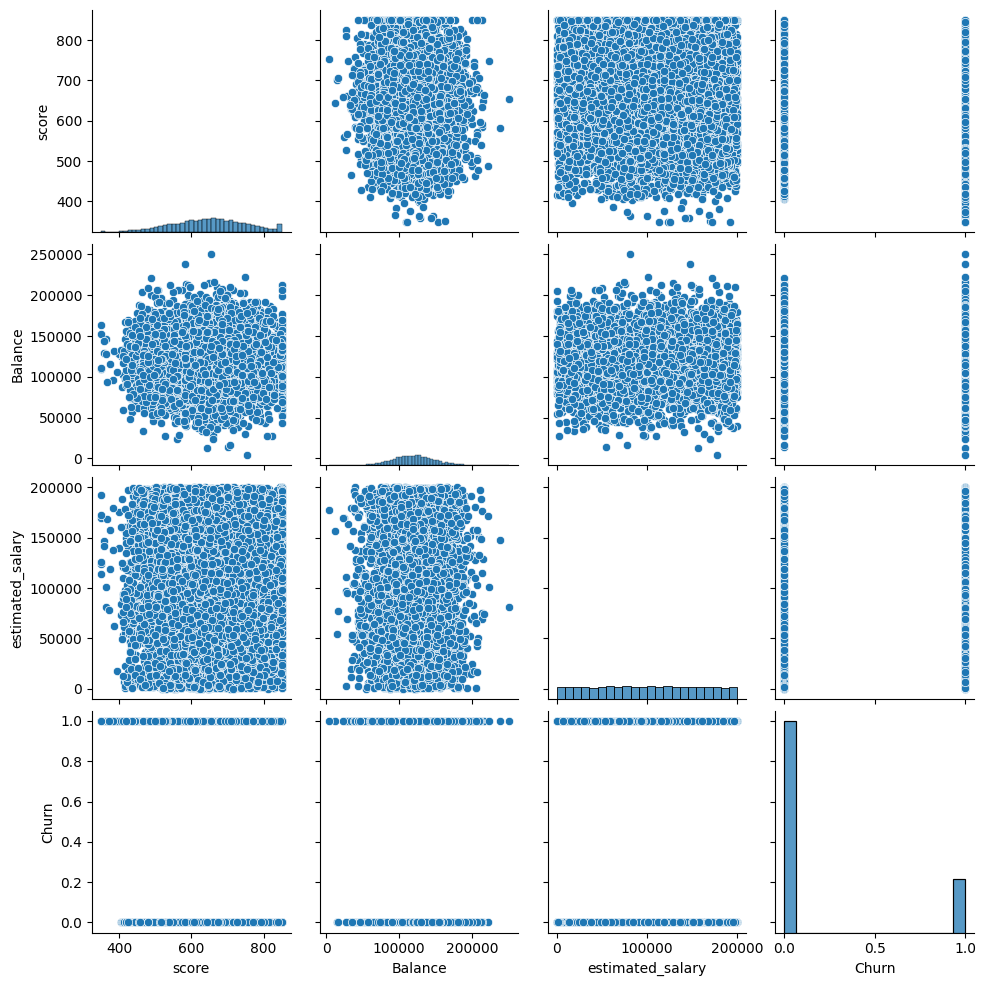

In [4]:
# строим диаграмму рассеивания 
sns.pairplot(df[lst])

In [5]:
# строим матрицу парных коэффициентов корреляции (по умолчанию Пирсона)
df_corr = df[lst].corr()
df_corr

,score,Balance,estimated_salary,Churn
score,1.000000,-0.004744,-0.001384,-0.027094
Balance,-0.004744,1.000000,-0.001856,0.017208
estimated_salary,-0.001384,-0.001856,1.000000,0.012097
Churn,-0.027094,0.017208,0.012097,1.000000


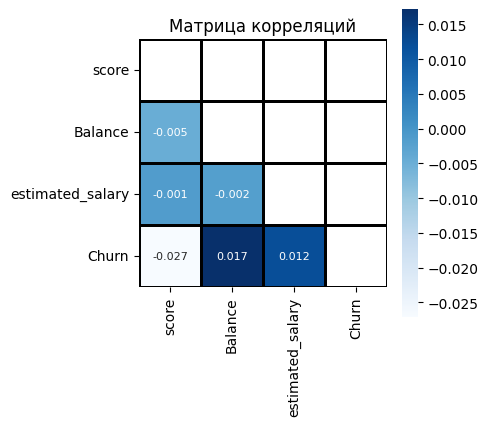

In [6]:
# строим тепловую карту, используя шаблон
fig, ax = plt.subplots(figsize=(4,4))
ax = sns.heatmap(data = df_corr, annot=True, square=True,
                 cmap='Blues', fmt='.3f', linewidths=1,
                 annot_kws={'size': 8},
                 linecolor='black', mask=np.triu(df_corr))
plt.title('Матрица корреляций')
plt.show()

In [7]:
#res = pointbiserialr(df['Churn'], df['score'])                    #statistic=(-0.027093539754658173), pvalue=(0.0067382138921916815))
res = pointbiserialr(df.dropna()['Churn'], df.dropna()['Balance']) #statistic=(0.017207790859182004), pvalue=(0.1692473489332224))
#res = pointbiserialr(df['Churn'], df['estimated_salary'])         #statistic=(0.012096861026844874), pvalue=(0.22644042802222883))
res

SignificanceResult(statistic=np.float64(0.017207790859182004), pvalue=np.float64(0.1692473489332224))

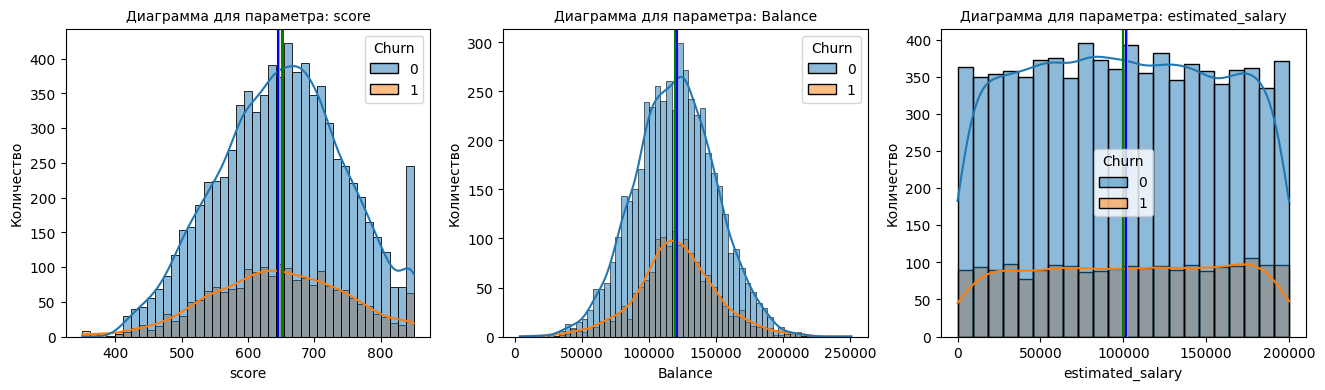

In [8]:
lst = ['score','Balance', 'estimated_salary']
plt.subplots(1,3, figsize=(16,4))
for index, col in enumerate(lst, start = 1):
    plt.subplot(1,3,index)
    ax = sns.histplot(data=df,
                x=col,
                hue = 'Churn',
                kde=True)
    ax.set_xlabel(f'{col}')
    ax.set_ylabel('Количество')
    ax.set_title((f'Диаграмма для параметра: {col}'),fontsize = 10)

    ax.axvline(df[df.Churn == 1][col].median(),
               color='orange'#,
               #label=f"Медиана {df[df.Churn == 1][col].median()}"
               )
    ax.axvline(df[df.Churn == 0][col].median(),
               color='red'#,
               #label=f"Медиана {df[df.Churn == 0][col].median()}"
               )
    ax.axvline(df[df.Churn == 1][col].mean(),
               color='blue'#,
               #label=f"Среднее {df[df.Churn == 1][col].mean()}"
               )
    ax.axvline(df[df.Churn == 0][col].mean(),
               color='green'#,
               #label=f"Среднее {df[df.Churn == 0][col].mean():.1}"
               )
#plt.legend()


In [9]:
lst_cont = ['score', 'Balance', 'estimated_salary']
df.groupby('Churn')[lst_cont].agg(['mean', 'median'])

score               Balance             estimated_salary  \
             mean median           mean      median             mean   
Churn                                                                  
0      651.853196  653.0  119535.864270  119791.215     99738.391772   
1      645.351497  646.0  120746.971132  119948.090    101465.677531   

                  
          median  
Churn             
0       99645.04  
1      102460.84

Создаем гипотезы по законам распределения для каждого признака,  для этого формируем выборки для каждого признака

- H_0 -- F(x) -- имеет нормальный закон распределения
- H_1 -- F(x) -- имеет закон распределения, отличный от нормального
- H_0 -- F(y) -- имеет нормальный закон распределения
- H_1 -- F(y) -- имеет закон распределения, отличный от нормального

In [10]:
# проверяем выборки
lst_cont = ['score', 'Balance', 'estimated_salary']
for col in lst_cont:
    x = df[df['Churn']==0][col]
    y = df[df['Churn']==1][col]
    #display(f'col x {x.shape[0]}')  #'col x 7963'
    #display(f'col y {y.shape[0]}')  #'col y 2037'
    alpha = 0.05
    statist, p_valye = shapiro(y, nan_policy='omit')
    if p_valye < alpha:
        print(f"""Гипотезу H_0 отвергаем, распределение  `y` отлично от нормального.
p-value = {p_valye}""")
    else:
        print(f"""Гипотезу H_0 примимаем, распределение `y` нормальное.
p-value = {p_valye}""") 

Гипотезу H_0 отвергаем, распределение  `y` отлично от нормального.
p-value = 1.230572014622469e-07
Гипотезу H_0 отвергаем, распределение  `y` отлично от нормального.
p-value = 1.0686479433587167e-08
Гипотезу H_0 отвергаем, распределение  `y` отлично от нормального.
p-value = 4.595982802849635e-25


In [11]:
lst_cont = ['score', 'Balance', 'estimated_salary']
for col in lst_cont:
    x = df[df['Churn']==0][col]
    y = df[df['Churn']==1][col]
    print(ks_2samp(x,y, nan_policy='omit'))

KstestResult(statistic=np.float64(0.03584823549712708), pvalue=np.float64(0.030059908312210937), statistic_location=np.int64(651), statistic_sign=np.int8(-1))
KstestResult(statistic=np.float64(0.0556663787263191), pvalue=np.float64(0.0013792372742761922), statistic_location=np.float64(104450.86), statistic_sign=np.int8(1))
KstestResult(statistic=np.float64(0.02351751913966849), pvalue=np.float64(0.32498799277316914), statistic_location=np.float64(106149.48), statistic_sign=np.int8(1))


In [12]:
lst_cont = ['score', 'Balance', 'estimated_salary']

for col in lst_cont:
    alpha = 0.05
    statistic, p_valye = kstest(df[df.Churn == 0][col], 'norm', args=(df[df.Churn == 0][col].mean(), 
                                                                    df[df.Churn == 0][col].std()), nan_policy='omit')
    if p_valye < alpha:
        print(f"""Гипотезу H_0 отвергаем, распределение 'x' отлично от нормального при Churn == 0 и {col}.
p-value = {p_valye}""")
    else:
        print(f"""Гипотезу H_0 примимаем, распределение 'x' нормальное при Churn == 0 и {col}.
p-value = {p_valye}""") 

    statistic, p_valye = kstest(df[df.Churn == 1][col], 'norm', args=(df[df.Churn == 1][col].mean(), 
                                                                    df[df.Churn == 1][col].std()), nan_policy='omit')
    if p_valye < alpha:
        print(f"""Гипотезу H_0 отвергаем, распределение 'y' отлично от нормального при Churn == 1 и {col}.
p-value = {p_valye}""")
    else:
        print(f"""Гипотезу H_0 примимаем, распределение 'y' нормальное при Churn == 1 и {col}.
p-value = {p_valye}""") 
        


Гипотезу H_0 отвергаем, распределение 'x' отлично от нормального при Churn == 0 и score.
p-value = 0.005718288730057571
Гипотезу H_0 примимаем, распределение 'y' нормальное при Churn == 1 и score.
p-value = 0.3437391055014972
Гипотезу H_0 примимаем, распределение 'x' нормальное при Churn == 0 и Balance.
p-value = 0.9474815181540325
Гипотезу H_0 отвергаем, распределение 'y' отлично от нормального при Churn == 1 и Balance.
p-value = 0.010708894370023666
Гипотезу H_0 отвергаем, распределение 'x' отлично от нормального при Churn == 0 и estimated_salary.
p-value = 1.7444461482522312e-21
Гипотезу H_0 отвергаем, распределение 'y' отлично от нормального при Churn == 1 и estimated_salary.
p-value = 2.901500224918054e-07


In [13]:
lst_cont = ['score', 'Balance', 'estimated_salary']
for col in lst_cont:
  print(
    kstest(df[df.Churn == 1][col], 'norm',
       args=(df[df.Churn == 1][col].mean(), df[df.Churn == 1][col].std()), nan_policy='omit')
     )   
  print(
    kstest(df[df.Churn == 0][col], 'norm',
       args=(df[df.Churn == 0][col].mean(), df[df.Churn == 0][col].std()), nan_policy='omit')
     )  

KstestResult(statistic=np.float64(0.02067881802276783), pvalue=np.float64(0.3437391055014972), statistic_location=np.int64(850), statistic_sign=np.int8(1))
KstestResult(statistic=np.float64(0.019156105528055578), pvalue=np.float64(0.005718288730057571), statistic_location=np.int64(850), statistic_sign=np.int8(1))
KstestResult(statistic=np.float64(0.04113384808551723), pvalue=np.float64(0.010708894370023666), statistic_location=np.float64(102870.93), statistic_sign=np.int8(-1))
KstestResult(statistic=np.float64(0.007475743969352133), pvalue=np.float64(0.9474815181540325), statistic_location=np.float64(121151.05), statistic_sign=np.int8(-1))
KstestResult(statistic=np.float64(0.062064082029797074), pvalue=np.float64(2.901500224918054e-07), statistic_location=np.float64(155799.86), statistic_sign=np.int8(-1))
KstestResult(statistic=np.float64(0.05514060451329511), pvalue=np.float64(1.7444461482522312e-21), statistic_location=np.float64(58019.95), statistic_sign=np.int8(1))


Мы получили доказательства, что признаки  `score`, `Balance` и `estimated_salary` в разрезе целевого признака `Churn` имеют различные законы распределения.

Поэтому проверяем статистики с помощью:

- критерия Манна-Уитни (проверяется гипотеза о равенстве выборочных средних или медиан)

- критерия Краскела-Уолиса (проверяется гипотеза о равенстве медиан величин)

Формулируем гипотезы:

- признак `score`- кредитный рейтинг
    - $H_0$ -- разница в кредитных рейтингах для оставшихся и ушедших клиентов статистически незначима;
    - $H_1$ -- разница в кредитных рейтингах для оставшихся и ушедших клиентов статистически значима; 

- признак `Balance`- баланс на счете
    - $H_0$ -- разница в балансе для оставшихся и ушедших клиентов статистически незначима;
    - $H_1$ -- разница в балансе для оставшихся и ушедших клиентов статистически значима; 

- признак `estimated_salary`- заработная плата 
    - $H_0$ -- разница в заработной плате для оставшихся и ушедших клиентов статистически незначима;
    - $H_1$ -- разница в заработной плате для оставшихся и ушедших клиентов статистически значима; 

In [14]:
lst_cont = ['score', 'Balance', 'estimated_salary']
for col in lst_cont:
    x = df[df['Churn']==0][col]
    y = df[df['Churn']==1][col]
    alpha = 0.05
    statist, p_valye = mannwhitneyu(x, y,
                                    nan_policy='omit')
    if p_valye < alpha:
        print(f"""Гипотезу о равенстве отвергаем, признак {col} влияет на целевой признак.
Клиенты, которые склонны к оттоку и клиенты, которые склонны остаться, отличаются.
p-value = {p_valye}""")
    else:
        print(f"""Гипотезу о равенстве примимаем, признак {col} не влияет на целевой признак.
p-value = {p_valye}""") 

Гипотезу о равенстве отвергаем, признак score влияет на целевой признак.
Клиенты, которые склонны к оттоку и клиенты, которые склонны остаться, отличаются.
p-value = 0.019868661172728338
Гипотезу о равенстве примимаем, признак Balance не влияет на целевой признак.
p-value = 0.22150885555919375
Гипотезу о равенстве примимаем, признак estimated_salary не влияет на целевой признак.
p-value = 0.22705150930153783


In [15]:
lst_cont = ['score', 'Balance', 'estimated_salary']
for col in lst_cont:
    x = df[df['Churn']==0][col]
    y = df[df['Churn']==1][col]
    alpha = 0.05
    statist, p_valye = kruskal(x, y,
                                    nan_policy='omit')
    if p_valye < alpha:
        print(f"""Гипотезу о равенстве отвергаем, признак {col} влияет на целевой признак.
Клиенты, которые склонны к оттоку и клиенты, которые склонны остаться, отличаются.
p-value = {p_valye}""")
    else:
        print(f"""Гипотезу о равенстве примимаем, признак {col} не влияет на целевой признак.
p-value = {p_valye}""") 

Гипотезу о равенстве отвергаем, признак score влияет на целевой признак.
Клиенты, которые склонны к оттоку и клиенты, которые склонны остаться, отличаются.
p-value = 0.019868433258160494
Гипотезу о равенстве примимаем, признак Balance не влияет на целевой признак.
p-value = 0.22150585375885248
Гипотезу о равенстве примимаем, признак estimated_salary не влияет на целевой признак.
p-value = 0.22704985515242243


##### Вывод

Из рассмотренных приpнаков только признак `score` влияет на целевой признак.

Клиенты, которые склонны к оттоку и клиенты, которые склонны остаться, отличаются.